# Data Pre-Processor

Authors: 
- Fábio D. Pacheco, up202502538
- Maximino Samarychev, up202107590
- Filipe Ramos, up202208996

Date: 24/11/2025

### Description

This notebook is used for the following purposes:
- Converts the data in .xslx format to .csv
- Process the dataset:
  - Performs data splice correction 
  - Compute a single average sample of all pseudo-replicates for the same sample
  - Create a labeled dataset


### Dependencies

In [27]:
import os
import pandas as pd
import openpyxl as pyxl
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import scipy as sci
import itertools as it

dataset_dir_path = "../dataset/"
dataset_path = dataset_dir_path + "dataset.xlsx"

print(f"Dataset path: {dataset_path}")

Dataset path: ../dataset/dataset.xlsx


### Data Conversion (from .xslx to .csv)

In [47]:
if( os.path.exists(dataset_path) ):
  metadata_dataset = pd.read_excel( dataset_path, sheet_name=1 )
  metadata_dataset.to_csv( dataset_dir_path + "metadata.csv", index=None, header=True )

  raw_dataset = pd.read_excel( dataset_path, sheet_name=2 )
  raw_dataset = (
    raw_dataset
      .drop(columns=['Unnamed: 0'])
      .rename(columns={'Unnamed: 1': 'wavelength'})
      .set_index('wavelength')
  )
  raw_dataset.to_csv(dataset_dir_path + "raw.csv", index=True, header=True)
else:
  print(f"No such dataset at path {dataset_path} ...")


### Load the raw and metadata files

In [30]:
raw_path      = dataset_dir_path + "raw.csv"
metadata_path = dataset_dir_path + "metadata.csv"

if( os.path.exists(dataset_path) ):
  metadata = pd.read_csv( metadata_path )
  raw = pd.read_csv(raw_path, index_col=0)

raw.columns = raw.columns.astype(int)

### Splice Correction 

In [33]:
def splice_correction(raw_df, threshold=0.01):
  corrected = raw_df.copy()

  for col in corrected.columns:
    # VIS correction (~650 nm)
    if 650 in corrected.index and 651 in corrected.index:
      diff_vis = corrected.loc[650, col] - corrected.loc[651, col]
      corrected.loc[corrected.index <= 650, col] -= diff_vis

    # SWIR2 correction (1800 or 1830 nm)
    if all(w in corrected.index for w in [1800, 1801, 1830, 1831]):
      diff_1800 = corrected.loc[1800, col] - corrected.loc[1801, col]
      diff_1830 = corrected.loc[1830, col] - corrected.loc[1831, col]

      max_diff = max(abs(diff_1800), abs(diff_1830))
      if max_diff < threshold:
        continue

      if abs(diff_1800) > abs(diff_1830):
        corrected.loc[corrected.index >= 1801, col] += diff_1800
      else:
        corrected.loc[corrected.index >= 1831, col] += diff_1830

    return corrected

In [38]:
raw = splice_correction(raw)

### Verify the dataset:
The values should be inside the interval: $[0, 1]$

In [35]:
stats = raw.describe( )

outside_mask = (raw < 0) | (raw > 1)

# Count how many entries are outside [0,1] per row
outside_per_row = outside_mask.sum(axis=1)

# Count how many rows have at least one value outside [0,1]
rows_with_outside = (outside_per_row > 0).sum()

# Count total number of entries outside [0,1]
total_outside = outside_mask.sum( ).sum( )

print(f"Rows with at least one value outside [0,1]: {rows_with_outside}")
print(f"Total entries outside [0,1]: {total_outside}")

Rows with at least one value outside [0,1]: 2151
Total entries outside [0,1]: 671309


### Average Pseudo-Replicate Samples and Remove Calibration Samples

In [6]:
# Available polymers
polymer_map = {
  'polyethylene terephthalate (PET)': 'Polyethylene terephthalate (PET)',
  'Polyethylene terephthalate (PET)': 'Polyethylene terephthalate (PET)',
  'Polypropylene (PP)': 'Polypropylene (PP)',
  'PP': 'Polypropylene (PP)',
  'Polyethylene (PE)': 'Polyethylene (PE)',
  'PE': 'Polyethylene (PE)',
  'Polystyrene (PS)': 'Polystyrene (PS)',
  'Extruded polystyrene': 'Polystyrene (PS)',
  'PVC': 'Polyvinylchloride (PVC)',
  'polyvinylchloride (PVC)': 'Polyvinylchloride (PVC)',
  'Thermoplastic elastomer': 'Thermoplastic elastomer',
  'Paraffin': 'Paraffin',
  'Fluorocarbon': 'Fluorocarbon',
  'polyamide (nylon)': 'Polyamide (Nylon)',
  'Unknown': 'Unknown'
}

calibrationSamples = [ 
  "White_reference ", 
  "Water_16_sediment", 
  "Wood_d_NA_NA_PoA_field", 
  "Clear water" , 
  "Water_1500_algae", 
  "Water_3000_algae", 
  "Water_4_sediment", 
  "Black_cloth_calibrationFacility"
]

# List of polymers to keep
top_polymers = {
  'pet':'Polyethylene terephthalate (PET)',
  'pp' :'Polypropylene (PP)',
  'pe' :'Polyethylene (PE)',
  'ps' :'Polystyrene (PS)'
}

In [37]:
# Exclude calibration samples while ensuring same index as raw.columns
valid = ~metadata['Sample code'].isin(calibrationSamples)

# Create group ID: increments at each new pseudo-replicate sequence
group_id = metadata['Pseudo-replicates'].eq( 1 ).cumsum( )

# Filter to valid columns
group_id_valid = group_id[valid]

# Compute mean across pseudo-replicates
raw_valid = raw.loc[:, valid]
mean_samples = raw_valid.T.groupby(group_id_valid).mean( ).T

# Get the label for the sample
metadata_valid = metadata.loc[valid].copy( )

# Define a function to get polymer type from multiple sources
def get_polymer_type(row):
  for col in ['Polymer identified via microFTIR', 'EMODnet micro-litter polymer type', 'Polymer commercial labeling ']:
    if pd.notna(row[col]) and row[col] != 'ND':
        return row[col]
    
  if pd.notna(row['Sample code']) and row['Sample code'] != 'ND':
    code = row['Sample code'].lower()
    if 'pp' in code:
      return 'Polypropylene (PP)'
    elif 'pe' in code:
      return 'Polyethylene (PE)'
    elif 'ps' in code:
      return 'Polystyrene (PS)'
    elif 'pet' in code:
      return 'Polyethylene terephthalate (PET)'
  return 'Unknown'

# Apply function to valid metadata
metadata_valid['polymer_type_final'] = metadata_valid.apply(get_polymer_type, axis=1)

# Map each pseudo-replicate group to its polymer type using the first occurrence in each group (all replicates in a group are same polymer)
group_polymer = metadata_valid.groupby(group_id_valid)['polymer_type_final'].first()

# Assign polymer type to mean_samples
mean_samples_polymer = mean_samples.copy( )

# Map group IDs to polymer types
polymer_names = [group_polymer[i] for i in mean_samples_polymer.columns]

# Normalize polymer names
mean_samples_polymer.columns = [polymer_map.get(name, 'Unknown') for name in polymer_names]

print(f"The size of the exported matrix is {mean_samples_polymer.shape}")
print( mean_samples_polymer.head( 5 ) )

The size of the exported matrix is (2151, 1069)
            Polypropylene (PP)  Polystyrene (PS)  \
wavelength                                         
350                   0.279895          0.080851   
351                   0.279861          0.082573   
352                   0.277043          0.072646   
353                   0.281552          0.070177   
354                   0.280615          0.074625   

            Polyethylene terephthalate (PET)  \
wavelength                                     
350                                 0.349557   
351                                 0.354230   
352                                 0.356104   
353                                 0.356454   
354                                 0.359986   

            Polyethylene terephthalate (PET)  Polyethylene (PE)  \
wavelength                                                        
350                                 0.037285           0.366505   
351                                 0.042852     

### Export the dataset

In [39]:
mean_samples_polymer.to_csv( dataset_dir_path + "ready_dataset.csv", index=True, header=True )

### Statistics about the dataset

In [4]:
dataset_path = dataset_dir_path + "ready_dataset.csv"

if( os.path.exists(dataset_path) ):
  dataset = pd.read_csv( dataset_path, index_col=0 )

# Extract the base polymer name (remove any suffix like .1, .2, etc.)
# And count the occurrences of each polymer type
base_polymers = dataset.columns.str.replace(r"\..*$", "", regex=True)
polymer_counts = base_polymers.value_counts()

print(polymer_counts)

Polyethylene terephthalate (PET)    375
Polypropylene (PP)                  266
Polyethylene (PE)                   228
Polystyrene (PS)                    180
Polyvinylchloride (PVC)              11
Unknown                               3
Thermoplastic elastomer               2
Paraffin                              2
Fluorocarbon                          1
Polyamide (Nylon)                     1
Name: count, dtype: int64


### Data division 

Based on the number of samples available for each polymer, the following were chosen for classification:
- PET, PP, PE and PS  

In [7]:
pet = dataset[[col for col in dataset.columns if col.startswith(top_polymers['pet'])]]
pp  = dataset[[col for col in dataset.columns if col.startswith(top_polymers['pp'])]]
pe  = dataset[[col for col in dataset.columns if col.startswith(top_polymers['pe'])]]
ps  = dataset[[col for col in dataset.columns if col.startswith(top_polymers['ps'])]]

# Combine into one dataset
dataset_classification = pd.concat([pet, pp, pe, ps], axis=1)

# Check shapes
print("PET shape:", pet.shape)
print("PP shape:", pp.shape)
print("PE shape:", pe.shape)
print("PS shape:", ps.shape)
print("Classification shape:", dataset_classification.shape)

# Create labels for each column (sample)
labels = []
for col in dataset_classification.columns:
  for key, val in top_polymers.items():
    if col.startswith(val):
      labels.append(key.upper())
      break

# Transpose so that samples are rows
dataset_classification = dataset_classification.T
dataset_classification['polymer'] = labels

# Separate features and labels
X = dataset_classification.drop(columns=['polymer'])
y = dataset_classification['polymer']

# Stratified train/test split
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
  X, y,
  test_size=0.2,      # 20% test set
  stratify=y,         # maintain polymer distribution
  random_state=42
)

# Check shapes and distribution
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print(y_train.value_counts( ))
print(y_test.value_counts( ))

PET shape: (2151, 375)
PP shape: (2151, 266)
PE shape: (2151, 228)
PS shape: (2151, 180)
Classification shape: (2151, 1049)
X_train shape: (839, 2151)
X_test shape: (210, 2151)
polymer
PET    300
PP     213
PE     182
PS     144
Name: count, dtype: int64
polymer
PET    75
PP     53
PE     46
PS     36
Name: count, dtype: int64


### Data Augmentation
- Additive Gaussian noise (sensor noise)

\begin{equation}
s'(\lambda) = s(\lambda) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)
\end{equation}

In [8]:
def AWGN(X, sigma=0.002):
  noise = np.random.normal(0, sigma, X.shape)
  return X + noise

- Multiplicative intensity scaling (illumination variation)

\begin{equation}
  s'(\lambda) = s(\lambda) \, \alpha, \quad \alpha \in [a_m, a_M]
\end{equation}

In [9]:
def intensity_scaling(X, scale_range=(0.95, 1.05)):
  scales = np.random.uniform( *scale_range, size=(X.shape[0], 1) )
  return X * scales

- Spectral shift (wavelength misalignment)

\begin{equation}
  s'(\lambda) = s(\lambda + \Delta \, \lambda) , \quad \Delta \, \lambda \in \{-1, 0, 1\}
\end{equation}

In [10]:
def spectral_shift(X, max_shift=1, random_state=None):
  rng = np.random.default_rng( random_state )

  X_np = X.to_numpy()
  shifted = np.zeros_like( X_np )

  for i in range(X_np.shape[0]):
    shift_val = rng.integers(-max_shift, max_shift + 1)
    shifted[i] = sci.ndimage.shift(
      X_np[i],
      shift=shift_val,
      mode='nearest',
      order=1  # linear interpolation 
    )

  return pd.DataFrame( shifted, index=X.index, columns=X.columns )

### Export the data ready for training and testing

In [42]:
# Export the data
X_train.to_csv( dataset_dir_path + "xtrain.csv", index=True, header=True )
X_test.to_csv ( dataset_dir_path + "xtest.csv" , index=True, header=True )
y_train.to_csv( dataset_dir_path + "ytrain.csv", index=True, header=True )
y_test.to_csv ( dataset_dir_path + "ytest.csv" , index=True, header=True )

### Generate and export the dataset augmented 

Scale:(1, 1), sigma:0.0005


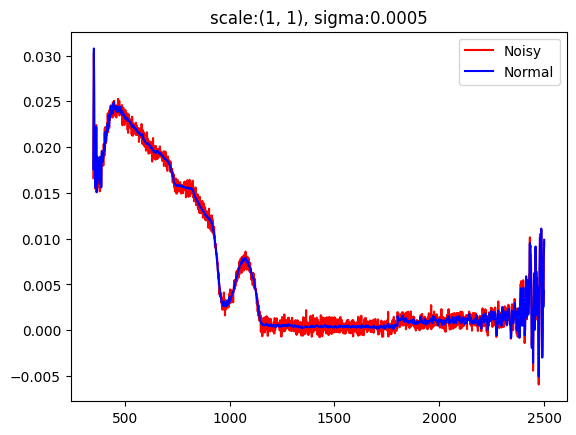

Scale:(0.9, 1), sigma:0.0005


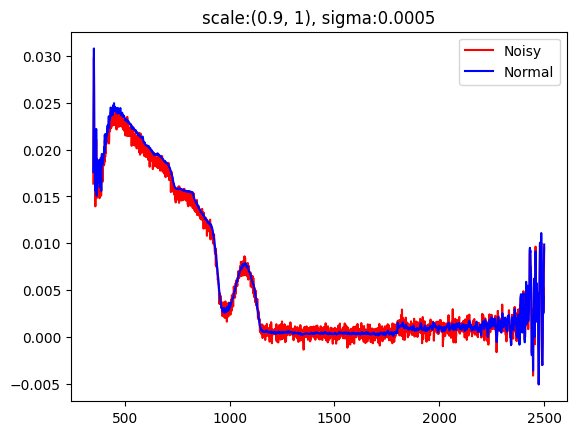

Scale:(0.8, 1), sigma:0.0005


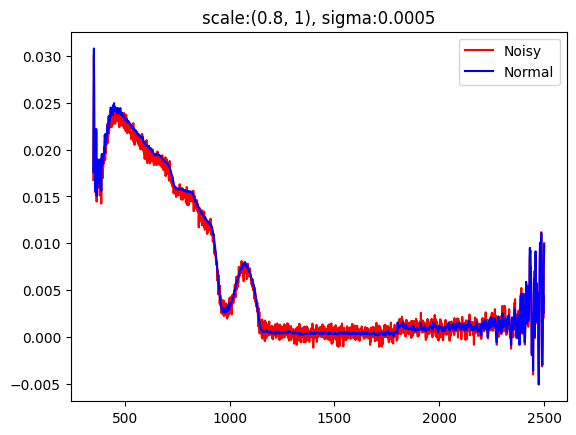

Scale:(0.7, 1), sigma:0.0005


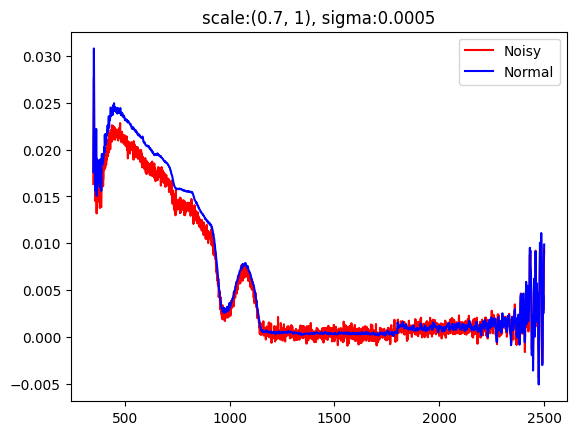

Scale:(1, 1.1), sigma:0.0005


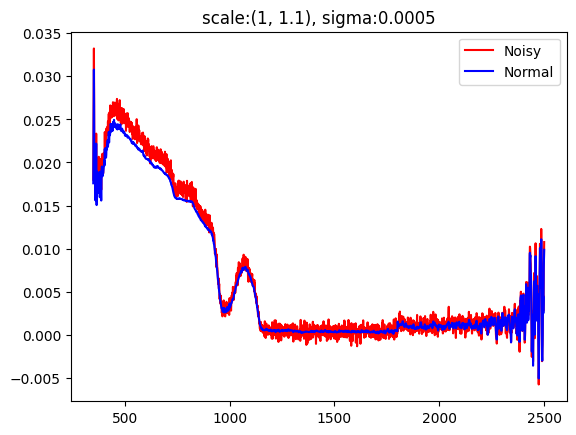

Scale:(1, 1.2), sigma:0.0005


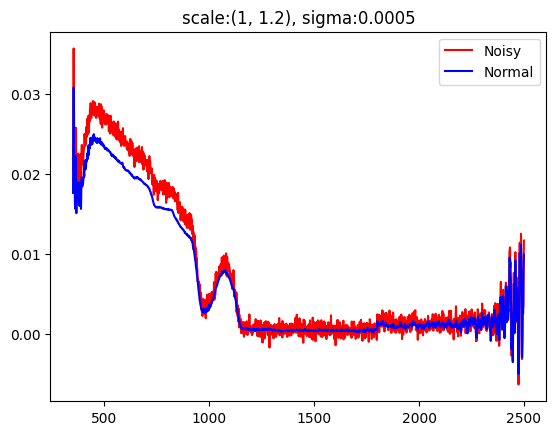

Scale:(1, 1.3), sigma:0.0005


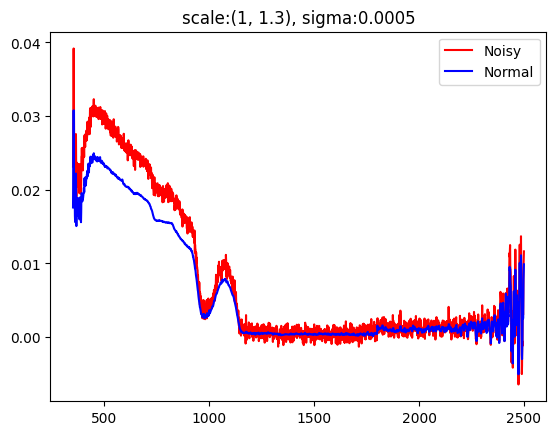

Scale:(0.9, 1.1), sigma:0.0005


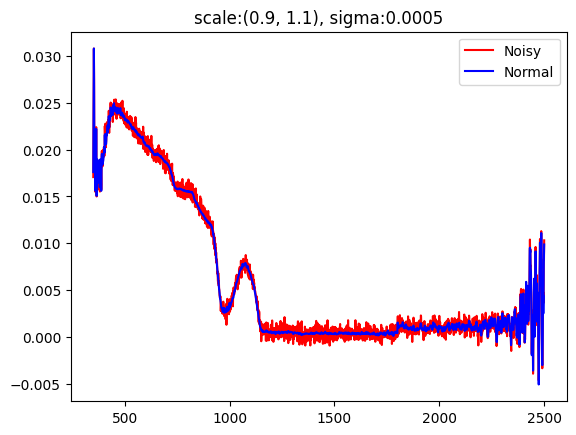

Scale:(0.8, 1.2), sigma:0.0005


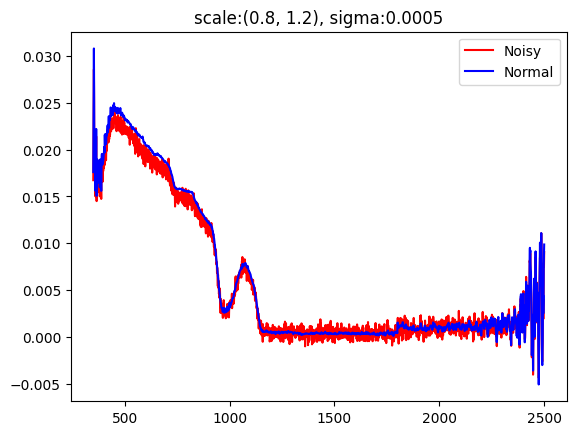

Scale:(0.7, 1.3), sigma:0.0005


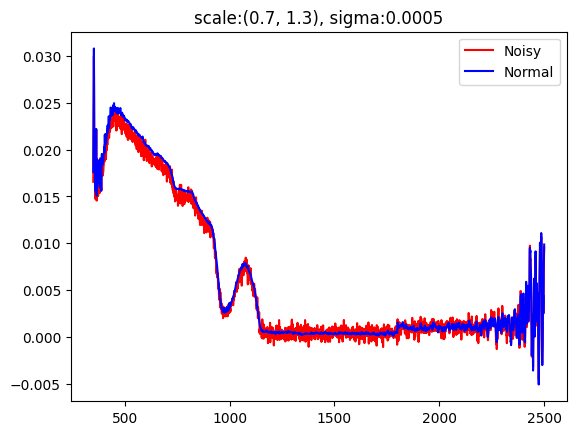

Scale:(1, 1), sigma:0.001


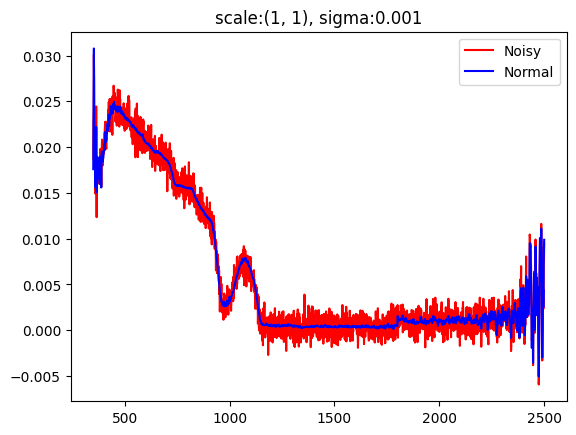

Scale:(0.9, 1), sigma:0.001


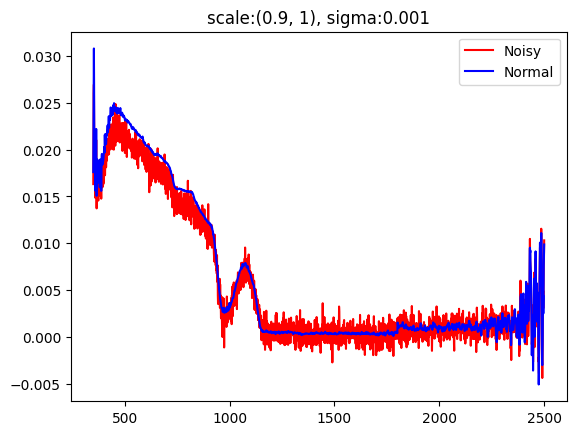

Scale:(0.8, 1), sigma:0.001


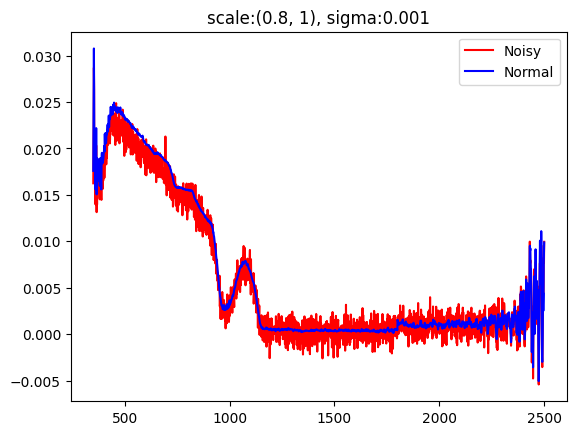

Scale:(0.7, 1), sigma:0.001


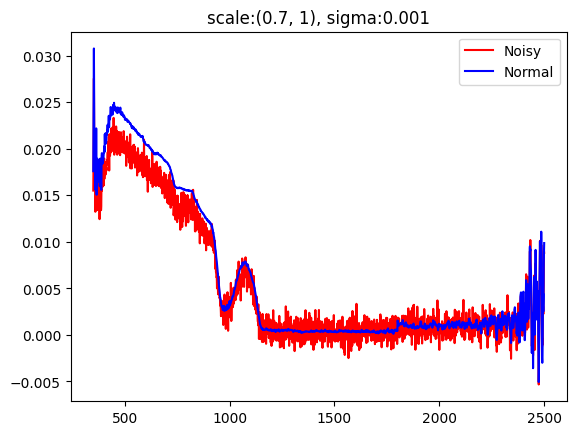

Scale:(1, 1.1), sigma:0.001


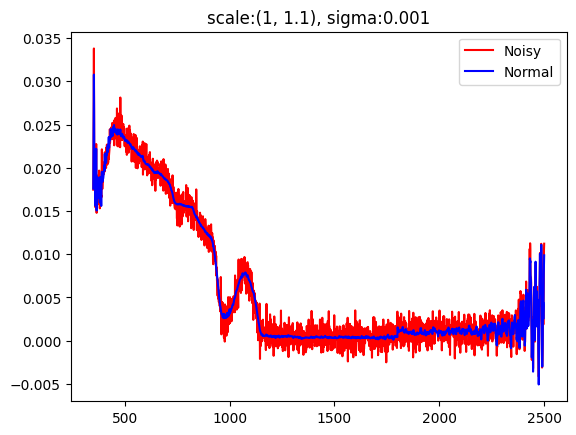

Scale:(1, 1.2), sigma:0.001


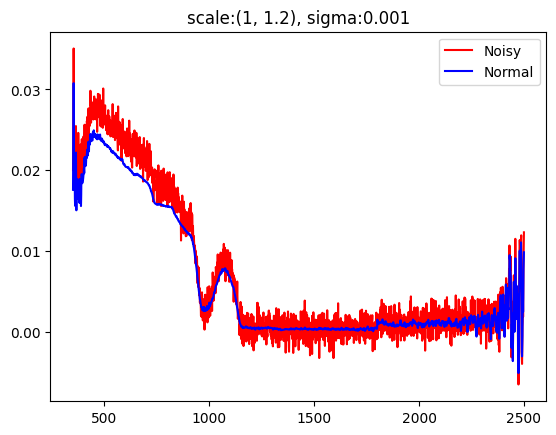

Scale:(1, 1.3), sigma:0.001


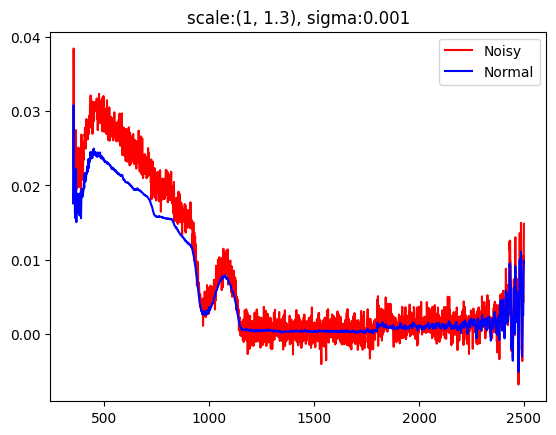

Scale:(0.9, 1.1), sigma:0.001


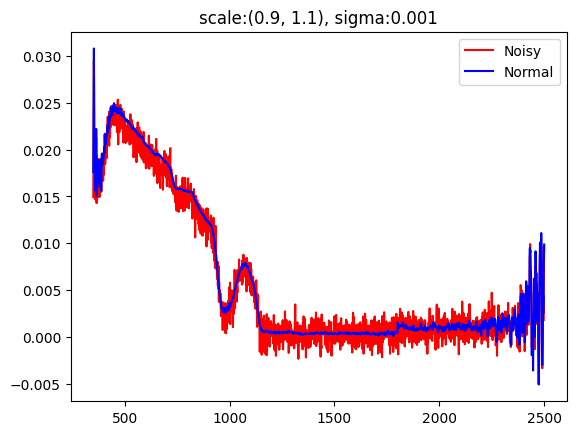

Scale:(0.8, 1.2), sigma:0.001


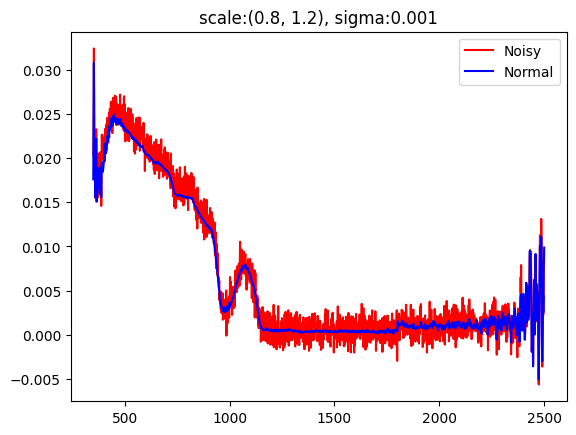

Scale:(0.7, 1.3), sigma:0.001


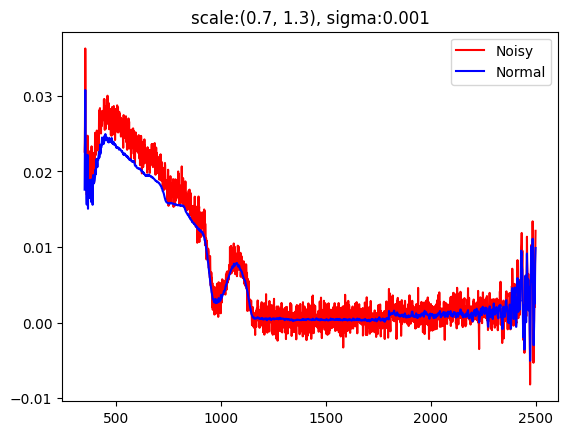

Scale:(1, 1), sigma:0.002


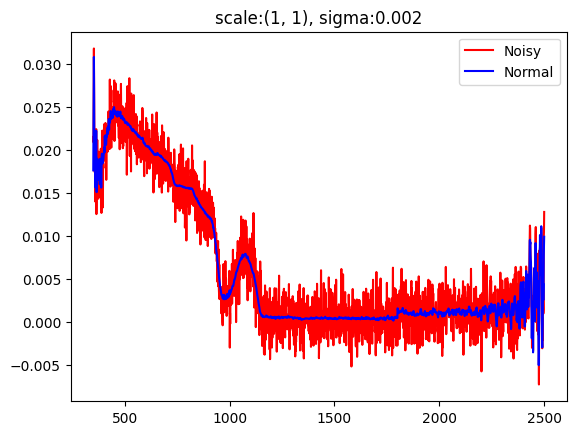

Scale:(0.9, 1), sigma:0.002


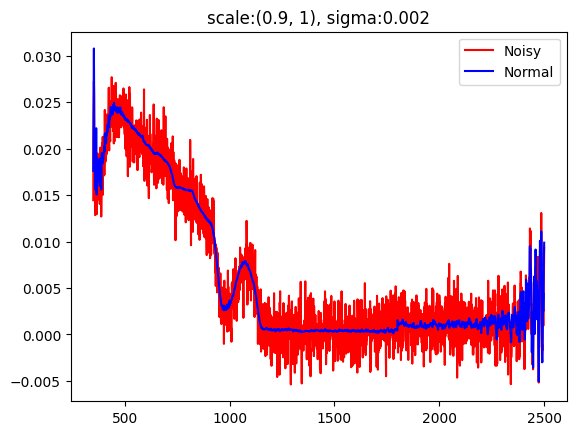

Scale:(0.8, 1), sigma:0.002


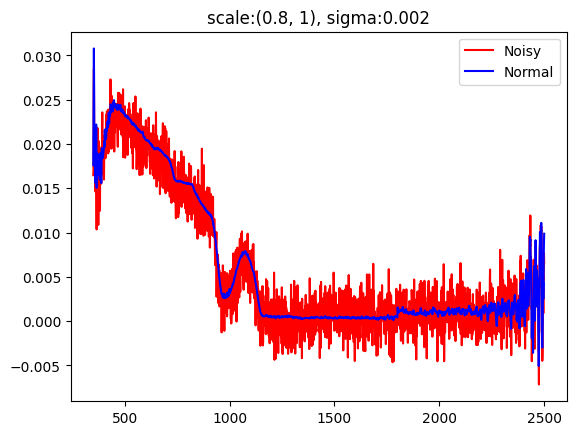

Scale:(0.7, 1), sigma:0.002


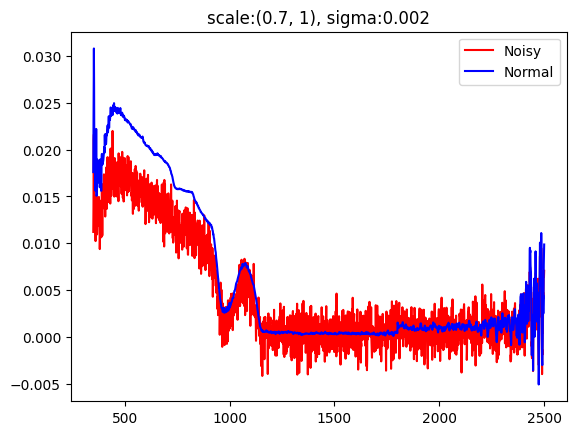

Scale:(1, 1.1), sigma:0.002


In [ ]:
variances = [5e-4, 1e-3, 2e-3]
scales = [
  (1,1), 
  (0.9, 1),   (0.8, 1),   (0.7, 1),
  (1, 1.1),   (1, 1.2),   (1, 1.3),
  (0.9, 1.1), (0.8, 1.2), (0.7, 1.3),
]

for sigma, scale in it.product(variances, scales):
  print(f"Scale:{scale}, sigma:{sigma}")
  X_new = AWGN( X_train, sigma )
  X_new = intensity_scaling( X_new, scale )

  s1_int = int(scale[0] * 10)
  s2_int = int(scale[1] * 10)
  sig = f"{sigma*10:.3f}".replace(".", "")
  filename = f"augmented/xtrain_sig{sig}_sca{s1_int:02d}_{s2_int:02d}.csv"
  save_path = os.path.join(dataset_dir_path, filename)
  X_new.to_csv(save_path, index=True, header=True)

  sample = 205
  plt.plot( X_new.iloc[sample, :], 'r-', label='Noisy' )
  plt.plot( X_train.iloc[sample, :], 'b-', label='Normal' )
  plt.legend( )
  plt.title(f"scale:{scale}, sigma:{sigma}")
  plt.show( )
